Sieci konwolucyjne

In [14]:
import torchvision
from torchvision import transforms
import torch
import torch.nn as nn

In [15]:
# Zbiór trenigowy
train_d = torchvision.datasets.MNIST(root='./data',
                                     train=True,
                                     download=True,
                                     transform=transforms.ToTensor())
# Zbiór testowy
test_d = torchvision.datasets.MNIST(root='./data',
                                    train=False,
                                    download=False,
                                    transform=transforms.ToTensor())

In [16]:
len(train_d), len(test_d)

(60000, 10000)

In [17]:
train_d[0][0].shape

torch.Size([1, 28, 28])

In [18]:
# Modele klasyczne

X_train = train_d.data.numpy().reshape(60000, 28*28)
X_test = test_d.data.numpy().reshape(10000, 28*28)

y_train = train_d.targets.numpy()
y_test = test_d.targets.numpy()

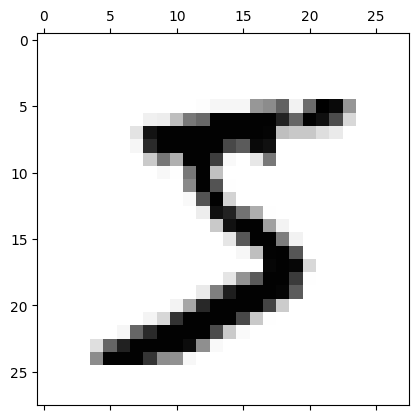

In [19]:
import matplotlib.pyplot as plt

plt.matshow(X_train[0].reshape(28,28), cmap='Greys')
plt.show()

In [20]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [22]:
from sklearn import metrics

print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1020
           1       0.99      0.98      0.98      1144
           2       0.95      0.93      0.94      1060
           3       0.94      0.92      0.93      1027
           4       0.95      0.94      0.95       994
           5       0.92      0.94      0.93       874
           6       0.95      0.96      0.96       943
           7       0.94      0.97      0.95      1005
           8       0.92      0.94      0.93       950
           9       0.92      0.95      0.94       983

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



In [23]:
# Model neuronowy
train_d = torch.utils.data.DataLoader(dataset=train_d,
                                      batch_size=50,
                                      shuffle=True)
test_d = torch.utils.data.DataLoader(dataset=test_d,
                                     batch_size=50,
                                     shuffle=False)

In [26]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # użyj karty graficznej (GPU) jeśli dostępna

class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2), # 1, bo jedna skala szarościi, 16 bo tyle będzie filtrów o rozm 5x5 przechodzę o 1, padding2 żeby nie zmieniać rozmiaru obrazka
        nn.BatchNorm2d(16), # normalizacja żeby nie wychodziły poza skalę, czyi coś jak standaryzacja
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)) # Obrazki po tym będa o połowę mniejsze, 28x28 -> 14x14
    self.layer2 = nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)) # 14 -> 7
    self.fc = nn.Linear(7*7*32, 10) # łącznie jest 32 obrazki 7x7

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.reshape(out.size(0), -1)
    out = self.fc(out)
    return out

# budujemy model
model = Model().to(device)

# Wybieramy funkcję kosztu i optymalizator
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Trenujemy model
for epoch in range(3):
  for i, (x, y) in enumerate(train_d):
    x = x.to(device)
    y = y.to(device)

    # Krof formard
    outputs = model(x)
    loss = criterion(outputs, y)

    # Krok backward i optymalizacja
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # coo 200 przejść wyświetla obezną fcję kosztu
    if (i+1) % 200 == 0:
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, 3, i+1, len(train_d), loss.item()))

# Testujemy model
model.eval() # model ustawiony w tryb evaluacji, niezbędny do batchnorm czy dropout

with torch.no_grad():
  correct = 0 # liczba poprawnie sklasyfikownych
  total = 0
  for x, y in test_d:
    x = x.to(device)
    y = y.to(device)
    outputs = model(x)
    _, predicted = torch.max(outputs.data, 1) # Indeks gdzie maksymalny logarytm prawdopodobieństwa
    total += y.size(0)
    correct += (predicted == y).sum().item()

  print(f'Dokładność na zbioerze testowym: {100*correct / total}')

Epoch [1/3], Step [200/1200], Loss: 0.0620
Epoch [1/3], Step [400/1200], Loss: 0.1447
Epoch [1/3], Step [600/1200], Loss: 0.0275
Epoch [1/3], Step [800/1200], Loss: 0.0612
Epoch [1/3], Step [1000/1200], Loss: 0.1279
Epoch [1/3], Step [1200/1200], Loss: 0.0111
Epoch [2/3], Step [200/1200], Loss: 0.0179
Epoch [2/3], Step [400/1200], Loss: 0.0905
Epoch [2/3], Step [600/1200], Loss: 0.0958
Epoch [2/3], Step [800/1200], Loss: 0.0164
Epoch [2/3], Step [1000/1200], Loss: 0.0487
Epoch [2/3], Step [1200/1200], Loss: 0.1175
Epoch [3/3], Step [200/1200], Loss: 0.0156
Epoch [3/3], Step [400/1200], Loss: 0.0056
Epoch [3/3], Step [600/1200], Loss: 0.0054
Epoch [3/3], Step [800/1200], Loss: 0.0357
Epoch [3/3], Step [1000/1200], Loss: 0.0945
Epoch [3/3], Step [1200/1200], Loss: 0.1968
Dokładność na zbioerze testowym: 98.69


Regularyzacja

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.34MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.52MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



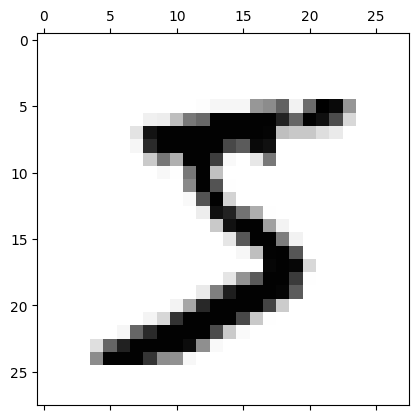

In [2]:
import torchvision
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


# Zbiór treningowy
train_dd = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transforms.ToTensor())
# Zbiór testowy
test_dd = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=False,
                                     transform=transforms.ToTensor())

# Przykładowe zdjęcie
im1 = train_dd.data.numpy().reshape(60000, 28*28)[0].reshape(28,28)
plt.matshow(im1.reshape(28,28), cmap='Greys')
plt.show()

In [4]:
train_dd = list(train_dd)
train_d = train_dd[:200]
valid_d = train_dd[200:1000]

train_d = torch.utils.data.DataLoader(train_d, batch_size=50) # 200 obserwacji = 4 x 50
valid_d = torch.utils.data.DataLoader(valid_d, batch_size=100) # paczki po 100
test_d = torch.utils.data.DataLoader(test_dd, batch_size=100) # paczki po 100

In [6]:
# Fcje do wyznaczania dokładności
def accuracy(model, data):
  with torch.no_grad():
    k = 0 # ile dobrze
    n = 0 # wszystkie
    model.eval()
    for x, y in data:
      output = model(x)
      pred = output.max(1, keepdim=True)[1] # Indeks gdzie maksymalny logarytm prawdopodobieństwa
      k += pred.eq(y.view_as(pred)).sum().item() # ile się pokrywa
      n += y.shape[0] # rozmiar batcha
    return k/n

def train_model(model):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  acc_train = []
  acc_valid = []

  # Trenujemy model
  r = 0
  acc_train.append(accuracy(model, train_d))
  acc_valid.append(accuracy(model, valid_d))
  r +=1
  for epoch in range(100):
    model.train()
    for i, (x, y) in enumerate(train_d):
      # Krok forward
      output = model(x)
      loss = criterion(output, y)

      # Krok backward i optymalizacja
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    acc_train.append(accuracy(model, train_d))
    acc_valid.append(accuracy(model, valid_d))
    r +=1

  plt.plot(range(r), acc_train, label='train', c='blue')
  plt.plot(range(r), acc_valid, label='valid', c='green')
  plt.legend()
  plt.show()

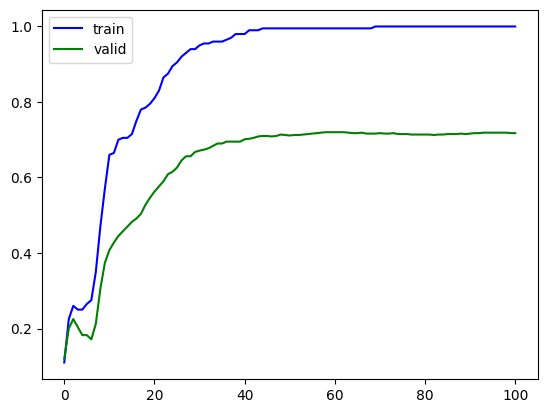

0.7289


In [7]:
class Model1(nn.Module):
  def __init__(self):
    super(Model1, self).__init__()
    self.layer1 = nn.Linear(28*28, 30)
    self.layer2 = nn.Linear(30, 15)
    self.layer3 = nn.Linear(15, 10)

  def forward(self, img):
    image_flat = img.view(-1, 28 * 28)
    out1 = F.relu(self.layer1(image_flat))
    out2 = F.relu(self.layer2(out1))
    out3 = self.layer3(out2)
    return out3

# budujemu model
model1 = Model1()
train_model(model1)
print(accuracy(model1, test_d))

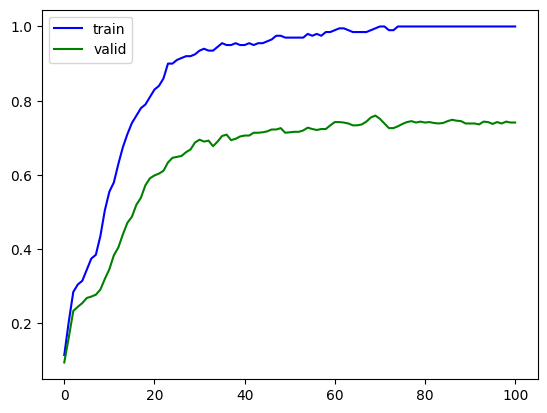

0.7289


In [9]:
# Dropout
# Wyłączamy połączenia. Parametr r pokazuje procent połączeń wyłączonych podczas procesu uczenia. Po testowaniu używamy sieci pełnej

class Model2(nn.Module):
  def __init__(self):
    super(Model2, self).__init__()
    self.layer1 = nn.Linear(28*28, 30)
    self.layer2 = nn.Linear(30, 15)
    self.layer3 = nn.Linear(15, 10)
    self.d1 = nn.Dropout(0.2)
    self.d2 = nn.Dropout(0.2)
    self.d3 = nn.Dropout(0.2)

  def forward(self, img):
    image_flat = img.view(-1, 28 * 28)
    out1 = F.relu(self.layer1(self.d1(image_flat)))
    out2 = F.relu(self.layer2(self.d2(out1)))
    out3 = self.layer3(self.d3(out2))
    return out3

# budujemu model
model2 = Model2()
train_model(model2)
print(accuracy(model2, test_d))

In [10]:
# Zwiększenie ilości danych
# poprzez obrót obrazka o kąt

my_transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.ToTensor()
]) # losowe obroty

train_d = []

for i in range(10):
  df = torchvision.datasets.MNIST(root='./data',
                                  train=True,
                                  download=True,
                                  transform=my_transform)
  for j, x in enumerate(df):
    if j == 200:
      break
    train_d.append(x)

print(len(train_d))

train_d = torch.utils.data.DataLoader(train_d, batch_size=50) # 200 obserwacji = 4 x 50 x 10

2000


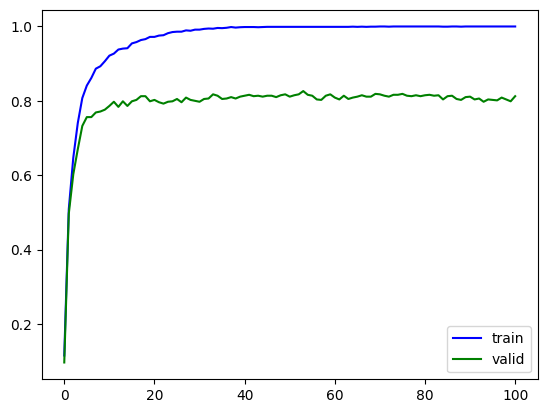

0.7289


In [11]:
# dane zwiększone 10-krotnie (każde zdjęcie 10 obrotów)
model2 = Model2()
train_model(model2)
print(accuracy(model2, test_d))

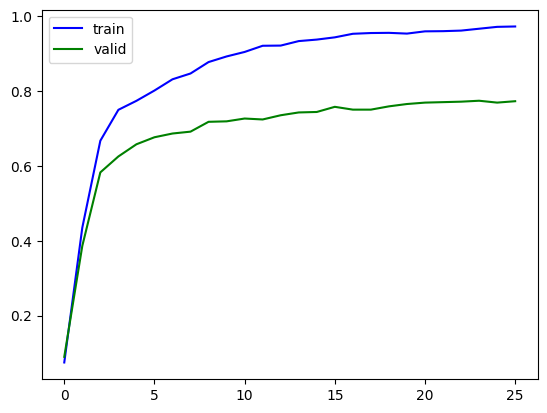

0.7754


In [12]:
# Regularyzacja L2 zapobiega dużym wagom i nadmiernej ich liczbie

# Dodana regularyzacja, zmniejszona liczba epok 4-krotnie

def train_model(model):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01) # Regularyzacja L2
  acc_train = []
  acc_valid = []

  # Trenujemy model
  r = 0
  acc_train.append(accuracy(model, train_d))
  acc_valid.append(accuracy(model, valid_d))
  r +=1
  for epoch in range(25):
    model.train()
    for i, (x, y) in enumerate(train_d):
      # Krok forward
      output = model(x)
      loss = criterion(output, y)

      # Krok backward i optymalizacja
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    acc_train.append(accuracy(model, train_d))
    acc_valid.append(accuracy(model, valid_d))
    r +=1

  plt.plot(range(r), acc_train, label='train', c='blue')
  plt.plot(range(r), acc_valid, label='valid', c='green')
  plt.legend()
  plt.show()

model2 = Model2()
train_model(model2)
print(accuracy(model2, test_d))

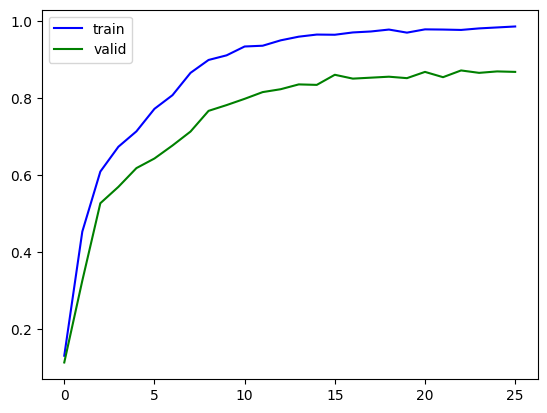

0.8422


In [13]:
# Weight sharing - dzielenie wag, tutaj konwolucja

class Model3(nn.Module):
  def __init__(self):
    super(Model3, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2), # 1 -> 6
        nn.BatchNorm2d(6),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer2 = nn.Sequential(
        nn.Conv2d(6, 8, kernel_size=5, stride=1, padding=2), # 6 -> 8
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))

    self.d1 = nn.Dropout(0.2)
    self.d2 = nn.Dropout(0.2)
    self.fc1 = nn.Linear(7*7*8, 4) # wymiar po konvolucjach
    self.fc2 = nn.Linear(4, 10)


  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)

    out = out.reshape(out.size(0), -1)

    out = self.fc1(self.d1(out))
    out = self.fc2(self.d2(out))
    return out


# budujemu model
model3 = Model3()
train_model(model3)
print(accuracy(model3, test_d))